# Community Detection

Detects communities in the network of users.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
import collections as clt
from community import best_partition,modularity
import itertools
from joblib import Parallel, delayed

In [2]:
df = pd.read_csv('reviews_full_v5.csv')

In [3]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots

In [4]:
G = nx.read_gpickle('network_users.p')

In [5]:
'''import pickle
pickle.dump(G, open( "network_users_G.p", "wb" ) )'''

'import pickle\npickle.dump(G, open( "network_users_G.p", "wb" ) )'

In [6]:
def calc_modular(Graph, n_iter):
    prob = {} #key is (node 1, node 2), value is number of times they are in the same cluster/total number of iterations
    total = 0
    for i in range(n_iter):# for n_iter number of iterations
        partition = best_partition(Graph, randomize = True, weight = 'weight')
        total += modularity(partition, Graph)
        mp = {}
        for user in partition:
            if partition[user] not in mp:
                mp[partition[user]]= []
            mp[partition[user]].append(user)
        ave_density = 0
        for part in mp:
            for u,v in itertools.combinations(mp[part],2):
                if (u,v) not in prob:
                    prob[(u,v)] = 0
                prob[(u,v)] += 1
            SG = Graph.subgraph(mp[part])
            n = len(mp[part])
            if n > 1:
                ave_density += len(SG.edges())/(n*(n-1)/2)
        ave_density /= len(mp)
    #return total/n_iter, ave_density ,np.mean([min(x,1-x) for x in prob.values()])#closeness to 0 or 1
    return total/n_iter, ave_density, len(Graph.edges()), np.mean([min(x,1-x) for x in prob.values()])

In [7]:
def freq_network(Graph, n_iter):#Graph is new frequency network
    E = sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)])
    print(nx.number_connected_components(Graph), E, len(Graph.edges()))
    #prob = {} #key is (node 1, node 2), value is number of times they are in the same cluster/total number of iterations
    total = 0
    G = nx.Graph()
    for i in range(n_iter):# for n_iter number of iterations
        partition = best_partition(Graph, randomize = True, weight = 'weight')
        mp = {}
        for user in partition:
            if partition[user] not in mp:
                mp[partition[user]]= []
            mp[partition[user]].append(user)
        for part in mp:
            for u,v in itertools.combinations(mp[part],2):
                if G.has_edge(u,v):
                    G[u][v]['weight'] += 1
                else:
                    G.add_edge(u,v,weight = 1)
    E = sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(G)])
    print(nx.number_connected_components(G), E, len(G.edges()))
    return G

In [8]:
'''import time
a = time.time()
prob,ave_mod,ave_prob = calc_modular(G,20)
print(time.time()-a)'''

'import time\na = time.time()\nprob,ave_mod,ave_prob = calc_modular(G,20)\nprint(time.time()-a)'

In [9]:
def modular_range(sim_x, Graph):
    #runs in linear time, but needs to be initialised from mallest to largest after reverse
    #takes in a range of values and adds edges individually from greatest to smallest similarity
    #used for range query
    #range query reduces run time as graph is only constructed once
    #returns list of modularity scores, density, etc.
    sim_x.reverse()
    pos = 0
    GC_split = nx.Graph()
    GC_split.add_nodes_from(Graph.nodes())
    edges = []
    for u,v in Graph.edges():
        edges.append((Graph[u][v]['similarity'],u,v))
    edges.sort(reverse = True)
    ret = []
    for sim in sim_x:
        for i in range(pos,len(edges)):
            edgesim, u, v = edges[i]
            if edgesim >= sim:
                GC_split.add_edge(u,v)
            else:
                pos = i
                break
        G1 = GC_split.copy()
        G1.remove_nodes_from(nx.isolates(GC_split))
        ret.append(calc_modular(G1,10))
    ret.reverse()
    sim_x.reverse()
    return ret

def filter_sim(Graph, sim,params = True):
    #this function generates a graph which is a collection of subgraphs from the original graph
    #after removing all edges with similarity < sim, where sim is to be determined
    #to generate full graph, used for point query
    GC_split = nx.Graph()
    GC_split.add_nodes_from(Graph.nodes())
    for u,v in Graph.edges():
        if Graph[u][v]['similarity'] >= sim:
            GC_split.add_edge(u,v)
            if params == True:
                GC_split[u][v]['weight'] = Graph[u][v]['weight']
                GC_split[u][v]['similarity'] = Graph[u][v]['similarity']
                GC_split[u][v]['releases'] = Graph[u][v]['releases']
                GC_split[u][v]['year'] = Graph[u][v]['year']
    return GC_split

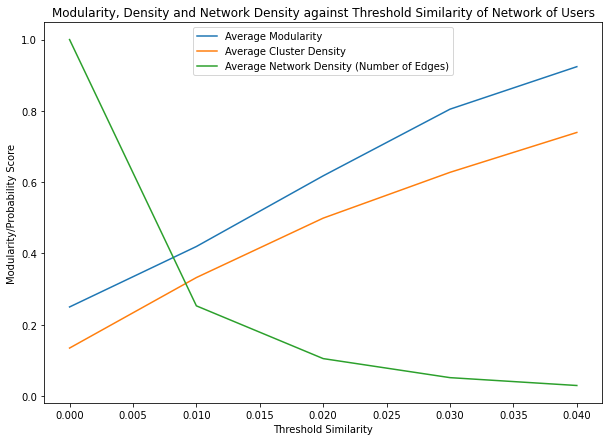

In [10]:
sim_x = [x/100 for x in range(5)]
ret = modular_range(sim_x,G)
mod_y = [x[0] for x in ret]
density_y = [x[1] for x in ret]
ave_y = [x[2] for x in ret]#average difference from 0 or 1
maxi = max(ave_y)
ave_y = np.array(ave_y)/maxi#normalised
plt.title('Modularity, Density and Network Density against Threshold Similarity of Network of Users')
plt.ylabel('Modularity/Probability Score')
plt.xlabel('Threshold Similarity')
plt.plot(sim_x,mod_y, label = 'Average Modularity')
plt.plot(sim_x,density_y, label = 'Average Cluster Density')
plt.plot(sim_x,ave_y, label = 'Average Network Density (Number of Edges)')
plt.legend()
plt.savefig('Modularity and Probability Score against Threshold Similarity of Network of Users.png')
plt.show()

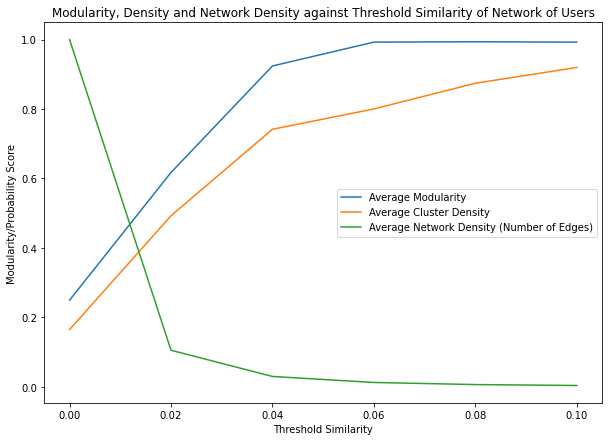

In [11]:
sim_x = [x/50 for x in range(6)]
ret = modular_range(sim_x,G)
mod_y = [x[0] for x in ret]
density_y = [x[1] for x in ret]
ave_y = [x[2] for x in ret]#average difference from 0 or 1
maxi = max(ave_y)
ave_y = np.array(ave_y)/maxi#normalised
plt.title('Modularity, Density and Network Density against Threshold Similarity of Network of Users')
plt.ylabel('Modularity/Probability Score')
plt.xlabel('Threshold Similarity')
plt.plot(sim_x,mod_y, label = 'Average Modularity')
plt.plot(sim_x,density_y, label = 'Average Cluster Density')
plt.plot(sim_x,ave_y, label = 'Average Network Density (Number of Edges)')
plt.legend()
plt.savefig('Modularity and Probability Score against Threshold Similarity of Network of Users (0-0.1).png')
plt.show()

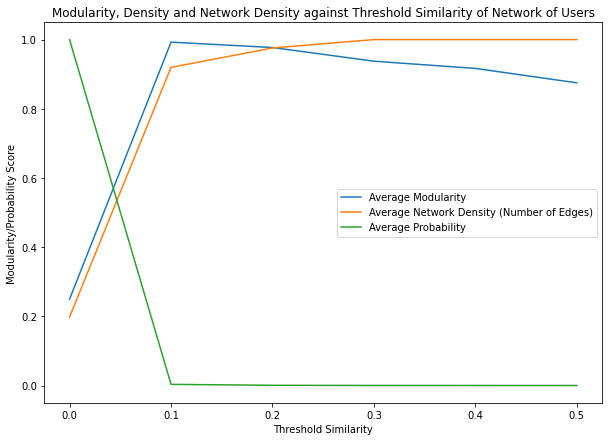

In [12]:
sim_x = [x/10 for x in range(6)]
ret = modular_range(sim_x,G)
mod_y = [x[0] for x in ret]
density_y = [x[1] for x in ret]
ave_y = [x[2] for x in ret]#average difference from 0 or 1
maxi = max(ave_y)
ave_y = np.array(ave_y)/maxi#normalised
plt.title('Modularity, Density and Network Density against Threshold Similarity of Network of Users')
plt.ylabel('Modularity/Probability Score')
plt.xlabel('Threshold Similarity')
plt.plot(sim_x,mod_y, label = 'Average Modularity')
plt.plot(sim_x,density_y, label = 'Average Network Density (Number of Edges)')
plt.plot(sim_x,ave_y, label = 'Average Probability')
plt.legend()
plt.savefig('Modularity and Probability Score against Threshold Similarity of Network of Users (all).png')
plt.show()

In [13]:
J = filter_sim(G,0.001)
nx.number_connected_components(J)

21

In [14]:
clt.Counter([len(cc) for cc in nx.connected_components(J)])

Counter({3555: 1, 2: 1, 1: 19})

In [15]:
len(list(nx.isolates(G)))
nx.number_connected_components(G)

1

In [16]:
#calc_modular(filter_sim(G,0.0005),10)[2]

Based on the above graph, it is decided that a threshold similarity of 0.002 is used.

In [17]:
genres = {}
temp = set()
for i,user in enumerate(df['User']):
    if user not in genres:
         genres[user] = set()
    if df['Genre'][i] != df['Genre'][i]:
        #genresNew.append('')
        continue
    #tmp = [x.replace("'",'').replace('"','').lstrip().rstrip() for x in df['Genre'][i][1:-1].split(',')]
    #genresNew.append(str(tmp)[1:-1].replace(', ','|').replace("'",''))
    genres[user].update(df['Genre'][i].lower().split('|'))
    temp.update(df['Genre'][i].lower().split('|'))

In [18]:
len(temp)

297

In [19]:
#H = filter_sim(G,0.001, False)
H = G
partition = best_partition(H, randomize = True)
parts = {}
mp = {}
for user in partition:
    if partition[user] not in parts:
        parts[partition[user]] = set()
        mp[partition[user]] = list()
    mp[partition[user]].append(user)
    parts[partition[user]].update(genres[user])

In [20]:
for item in mp:
    #if len(mp[item]) < 3:
        #continue
    print(item, len(mp[item]), len(parts[item]))

0 673 234
1 190 158
2 829 226
3 765 206
4 655 236
5 285 170
6 179 196


In [21]:
print(parts[4])

{'melodic hardcore', 'post-black metal', 'gothenburg metal', 'gothic metal', 'instrumental post-metal', 'progressive metal', 'folk metal', 'melodic doom metal', 'electronica', 'groove thrash metal', 'technical black metal', 'black n roll', 'industrial avantgarde metal', 'depressive black metal', 'pop rock', 'symphonic power metal', 'progressive deathcore', 'nu metal', 'industrial grindcore', 'neoclassical darkwave', 'progressive folk metal', 'death rock', 'death thrash metal', 'teutonic thrash metal', 'atmospheric black metal', 'us power metal', 'stoner metal', 'groove heavy metal', 'country rock', 'psychedelic black metal', 'drone doom metal', 'post-metal', 'experimental rock', 'psychedelic doom metal', 'death doom metal', 'horror punk', 'death metal', 'atmospheric rock', 'atmospheric sludge metal', 'industrial metal', 'doom death metal', 'celtic folk metal', 'technical death metal', 'melodic groove metal', 'heavy metal', 'melodic hard rock', 'ambient drone', 'progressive rock', 'prog

In [23]:
'''import pandas as pd
import numpy as np
df = pd.read_csv('reviews_full_v2-2.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
tmp = []
for item in df['Genre']:
    if item != item:
        tmp.append(np.nan)
    else:
        tmp.append(item.lower())
df['Genre'] = tmp
df.to_csv('reviews_full_v3.csv', index = False)'''

"import pandas as pd\nimport numpy as np\ndf = pd.read_csv('reviews_full_v2-2.csv')\ndf = df.loc[:, ~df.columns.str.contains('^Unnamed')]\ntmp = []\nfor item in df['Genre']:\n    if item != item:\n        tmp.append(np.nan)\n    else:\n        tmp.append(item.lower())\ndf['Genre'] = tmp\ndf.to_csv('reviews_full_v3.csv', index = False)"

In [24]:
list(df['Genre']).count(np.nan)/len(df)

0.2903867970974164

In [25]:
'''genres = set()
for item in df['Genre']:
    if item != item:
        continue
    genres.update(item.split('|'))

f = open('genres.txt','w')
    
for item in genres:
    f.write(item+'\n')
f.close()
len(genres)'''

"genres = set()\nfor item in df['Genre']:\n    if item != item:\n        continue\n    genres.update(item.split('|'))\n\nf = open('genres.txt','w')\n    \nfor item in genres:\n    f.write(item+'\n')\nf.close()\nlen(genres)"

In [26]:
def freq_network_parr(Graph, n_iter, n_jobs):#Graph is new frequency network
    partitions = Parallel(n_jobs=n_jobs)(delayed(best_partition)(Graph, randomize = True, weight = 'weight') for i in range(n_iter))
    #partitions = [best_partition(Graph, randomize = True, weight = 'weight') for i in range(n_iter)]
    N = sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)])
    print(nx.number_connected_components(Graph), N, len(Graph.edges()))
    prob = {} #key is (node 1, node 2), value is number of times they are in the same cluster/total number of iterations
    total = 0
    G = nx.Graph()
    for partition in partitions:# for n_iter number of iterations
        #partition = best_partition(Graph, randomize = True, weight = 'weight')
        mp = {}
        for user in partition:
            if partition[user] not in mp:
                mp[partition[user]]= []
            mp[partition[user]].append(user)
        for part in mp:
            for u,v in itertools.combinations(mp[part],2):
                if G.has_edge(u,v):
                    G[u][v]['weight'] += 1
                else:
                    G.add_edge(u,v,weight = 1)
    N = sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(G)])
    print(nx.number_connected_components(G), N, G.number_of_edges())
    return G

In [27]:
def no_crossedges(Graph):
    return sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]) == Graph.number_of_edges()

In [28]:
H = G.copy()
while not no_crossedges(H):
    H = freq_network_parr(H, 10, 4)
[len(cc) for cc in nx.connected_components(H)]

1 6392100.0 76459
1 6392100.0 3188873
1 6392100.0 3188873
1 6392100.0 1675574
1 6392100.0 1675574
4 1667963.0 1667963


[794, 737, 1216, 829]